In [1]:
!gzip -d data.jsonl.gz

In [255]:
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from statistics import mean
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np

In [30]:
!gzip -d data.jsonl.gz

import json
#opens json file.  Each entry in the list is a dictionary that corresponds to the information about one tweet 
#example: the first entry might read {'created_at': 'Tue Sep 29 23:59:58 +0000 2020', 'full_text': 'RT @DarDar458: #PresidentialDebate #Debates2020 #TrumpIsANationalDisgrace'}
with open('data.jsonl', 'r') as json_file:
    json_list = list(json_file)        

In [52]:
json_list_2 = []
for tweet in json_list:
    json_list_2.append(json.loads(tweet))
df = pd.DataFrame(json_list_2)

In [307]:
## make columns from information in the user column
df['user_description'] = df.user.apply(lambda x: x['description'])
df['user_followers'] = df_sub.user.apply(lambda x: x['followers_count'])
df['hashtags'] = df.entities.apply(lambda x: x['hashtags'])

In [308]:
def determine_party(col):
    '''
    Looks through text to identify whether the user's description classifies them as a democrat or republican
    
    Input: string
    Output: string ('Dem', 'Rep', or 'unk')
    '''
    dem = ['biden', 'harris', 'democrat', 'liberal', 'progressive', 'socialist', 'cnn', 'msnbc']
    republican = ['trump', 'pence', 'fox', 'examiner', 'breitbart', 'maga', 'republican', 'conservative', 'make america great', 'keep america great']
    count = 0
    for i in dem:
        if col.lower().find(i)>=0:
            count +=1
    for i in republican:
        if col.lower().find(i)>=0:
            count -=1
    if count > 0:
        return 'Dem'
    elif count == 0:
        return 'unk'
    elif count < 0:
        return 'Rep'

def about(col):
    '''
    Returns 'Trump' if a string mentions Trump and not Biden and returns 'Biden' if a string mentions Biden and not Trump
    
    Input: string
    Output: string
    '''
    if col.lower().find('trump') >=0 and col.lower().find('biden') < 0:
        return 'Trump'
    if col.lower().find('biden') >=0 and col.lower().find('trump') < 0:
        return 'Biden'
    else:
        return 'no_candidate'

In [309]:
df['party'] = df.user_description.apply(determine_party)
df['about'] = df['full_text'].apply(about)
df['retweet'] = df['full_text'].apply(lambda x: x.find('RT')>=0)

In [335]:
df['tweet_heard_round_the_world'] = df['full_text'].apply(
    lambda x: x.find('RT @realDonaldTrump: Tonight, @FLOTUS and I tested positive for COVID-19.') >=0)

My "party" filter classified 24,443 people as Republicanand 7810 people as Democrate.

In [310]:
df.party.value_counts()

unk    108084
Rep     24443
Dem      7810
Name: party, dtype: int64

When looking at all of the tweets, the number of tweets that exclusively mention Trump far outweigh those that only mention Biden

In [311]:
df.about.value_counts()

Trump           68201
no_candidate    48747
Biden           23389
Name: about, dtype: int64

When sorting by retweet count, it became clear that retweets are counted as separate tweets.  Trump's announcment that he had tested positive for covid is the secondmost retweeted tweet in that period, and it appears 3,120 times in our data set.

In [314]:
df[['full_text', 'retweet_count']].sort_values(by='retweet_count', ascending = False)

,full_text,retweet_count
15183,RT @taylorswift13: After stoking the fires of ...,452964
120841,"RT @realDonaldTrump: Tonight, @FLOTUS and I te...",412157
121963,"RT @realDonaldTrump: Tonight, @FLOTUS and I te...",412157
122276,"RT @realDonaldTrump: Tonight, @FLOTUS and I te...",412157
123039,"RT @realDonaldTrump: Tonight, @FLOTUS and I te...",412157
...,...,...
99992,@realDonaldTrump https://t.co/1PLb5cTKNJ,0
31282,Just another dead Black man in Trump's beady e...,0
100006,Is “Mother” going to let you stand in the same...,0
100008,@realhahnsolo @realDonaldTrump he cannot conde...,0


In [316]:
df.groupby('full_text').count().sort_values(by = 'retweet_count', ascending = False)

,created_at,id,id_str,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,...,lang,retweeted_status,extended_entities,withheld_in_countries,user_description,user_followers,hashtags,party,about,retweet
full_text,,,,,,,,,,,,,,,,,,,,,
"RT @realDonaldTrump: Tonight, @FLOTUS and I tested positive for COVID-19. We will begin our quarantine and recovery process immediately. We…",3120,3120,3120,3120,3120,3120,3120,0,0,0,...,3120,3120,0,1,3120,3120,3120,3120,3120,3120
RT @JoeBiden: I’m happy to report that Jill and I have tested negative for COVID. Thank you to everyone for your messages of concern. I hop…,1006,1006,1006,1006,1006,1006,1006,0,0,0,...,1006,1006,0,0,1006,1006,1006,1006,1006,1006
RT @realDonaldTrump: https://t.co/HUSFkHqsyC,660,660,660,660,660,660,660,0,0,0,...,660,660,660,0,660,660,660,660,660,660
RT @PeteButtigieg: Did the President of the United States just instruct a white supremacist group to “stand by”?,657,657,657,657,657,657,657,0,0,0,...,657,657,0,0,657,657,657,657,657,657
RT @realDonaldTrump: https://t.co/B4H105KVSs,578,578,578,578,578,578,578,0,0,0,...,578,578,578,0,578,578,578,578,578,578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Full Presidential Debate: President Trump and Joe Biden | WSJ https://t.co/4QBq7cgOA9 @YouTubeより,1,1,1,1,1,1,1,0,0,0,...,1,0,0,0,1,1,1,1,1,1
Full investigation.\n#BidenHarris2020\nhttps://t.co/3mM07ORWcs,1,1,1,1,1,1,1,1,1,1,...,1,0,0,0,1,1,1,1,1,1
Full load in that one. https://t.co/QnUEUXnOQI,1,1,1,1,1,1,1,0,0,0,...,1,0,0,0,1,1,1,1,1,1


In [223]:
b_t_ratio = df_sub.about.value_counts().loc['Biden']/df_sub.about.value_counts().loc['Trump']
print(f'Biden/Trump ratio with all retweets: {b_t_ratio:.4f}')

Biden/Trump ratio with all retweets: 0.3429


In [336]:
no_rt = df.drop_duplicates(subset=['full_text'])

In [331]:
no_rt.about.value_counts()

Trump           34733
no_candidate    27123
Biden           10890
Name: about, dtype: int64

At this point I decided to take out all but the first instance of a tweet.  When taking out duplicate retweets, the ratio of Biden to Trump tweets is roughly the same as before.

In [332]:
b_t_ratio = no_rt.about.value_counts().loc['Biden']/no_rt.about.value_counts().loc['Trump']
print(f'Biden/Trump ratio without duplicate retweets: {b_t_ratio:.4f}')

Biden/Trump ratio without duplicate retweets: 0.3135


In [337]:
df_biden = no_rt[no_rt['about'] == 'Biden']
df_trump = no_rt[no_rt['about'] == 'Trump']
print(f'The mean number of retweets for a Biden-focused tweet is {df_biden.retweet_count.mean():.0f} and the mean number of re-tweets for a Trump-focused tweet is {df_trump.retweet_count.mean():.0f}') 

The mean number of retweets for a Biden-focused tweet is 821 and the mean number of re-tweets for a Trump-focused tweet is 773


In [328]:
df_trump.sort_values(by = 'retweet_count', ascending = False).iloc[2, 2]

'1311908042993274880'

In [346]:
df_trump_no_covid = df_trump[df_trump['tweet_heard_round_the_world']==False]

In [347]:
df_trump_no_covid

,created_at,id,id_str,full_text,truncated,display_text_range,entities,source,in_reply_to_status_id,in_reply_to_status_id_str,...,retweeted_status,extended_entities,withheld_in_countries,user_description,user_followers,hashtags,party,about,retweet,tweet_heard_round_the_world
1,Tue Sep 29 23:59:58 +0000 2020,1311093394400333824,1311093394400333824,RT @DarDar458: #PresidentialDebate #Debates202...,False,"[0, 73]","{'hashtags': [{'text': 'PresidentialDebate', '...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,{'created_at': 'Tue Sep 29 23:55:42 +0000 2020...,NaN,NaN,Canadian 🇨🇦 Windmill Cancer Survivor. I follow...,31031,"[{'text': 'PresidentialDebate', 'indices': [15...",unk,Trump,True,False
3,Wed Sep 30 00:00:02 +0000 2020,1311093410737070086,1311093410737070086,RT @abbydphillip: Very reminiscent of pre-2018...,False,"[0, 108]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,{'created_at': 'Tue Sep 29 23:00:28 +0000 2020...,NaN,NaN,Politics reporter covering elections & voting ...,21737,[],unk,Trump,True,False
7,Wed Sep 30 00:00:10 +0000 2020,1311093442592743424,1311093442592743424,RT @realDonaldTrump: Thank you #Truckers4Trump...,False,"[0, 72]","{'hashtags': [{'text': 'Truckers4Trump', 'indi...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,None,...,{'created_at': 'Tue Sep 29 02:40:46 +0000 2020...,"{'media': [{'id': 1310422596324913152, 'id_str...",NaN,one of the broncos biggest fan ever,61,"[{'text': 'Truckers4Trump', 'indices': [31, 46]}]",unk,Trump,True,False
10,Wed Sep 30 00:00:15 +0000 2020,1311093465682386944,1311093465682386944,RT @ConElMazoDando: Revelan fraude millonario ...,False,"[0, 140]",{'hashtags': [{'text': 'MaduroNuestraVozEnLaON...,"<a href=""http://twitter.com/download/android"" ...",NaN,None,...,{'created_at': 'Tue Sep 29 12:04:03 +0000 2020...,NaN,NaN,Primer Teniente de la gloriosa FANB componente...,46,"[{'text': 'MaduroNuestraVozEnLaONU', 'indices'...",unk,Trump,True,False
17,Wed Sep 30 00:00:29 +0000 2020,1311093523794591744,1311093523794591744,@rodala2904 @eleazar_arocha Las causas de Trum...,False,"[28, 69]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/android"" ...",1.311092e+18,1311091892914970630,...,NaN,NaN,NaN,,143,[],unk,Trump,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140326,Fri Oct 02 23:59:40 +0000 2020,1312180481341878273,1312180481341878273,"""Trump has COVID""\n\nAll of Twitter: https://t...",False,"[0, 34]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,None,...,NaN,"{'media': [{'id': 1312180308599398400, 'id_str...",NaN,Bye bi,6470,[],unk,Trump,False,False
140330,Fri Oct 02 23:59:06 +0000 2020,1312180339821875201,1312180339821875201,RT @Variety: Twitter to Suspend Users Wishing ...,False,"[0, 97]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,{'created_at': 'Fri Oct 02 23:48:43 +0000 2020...,NaN,NaN,Artist. Idealist. Student of History. Guided b...,843,[],unk,Trump,True,False
140331,Fri Oct 02 23:59:08 +0000 2020,1312180348076187649,1312180348076187649,RT @MollyMerry1: @robreiner I think it would b...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,None,...,{'created_at': 'Fri Oct 02 21:42:08 +0000 2020...,NaN,NaN,PRESIDENT TRUMP SUCKS- ORANGE FACE,193,[],Rep,Trump,True,False
140335,Fri Oct 02 23:59:41 +0000 2020,1312180486840619008,1312180486840619008,RT @aaronjcarpenter: I can’t stress this enoug...,False,"[0, 140]","{'hashtags': [], 'symbols': [], 'user_mentions...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,...,{'created_at': 'Fri Oct 02 23:58:26 +0000 2020...,NaN,NaN,Retired Navy Pilot & proud Naval Academy gradu...,67360,[],Rep,Trump,True,Fals

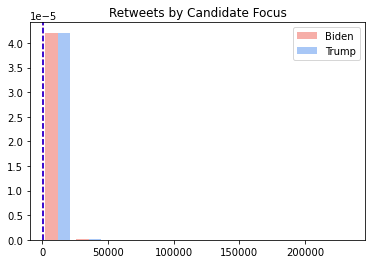

In [348]:
fig ,ax = plt.subplots()
ax.hist([df_biden.retweet_count, df_trump_no_covid.retweet_count], density = True, align = ('mid'), color = ['#F6AEA8', '#A8C7F6'], label = ['Biden', 'Trump'])
ax.spines["bottom"].set_visible(True)      
ax.spines["left"].set_visible(True)
ax.axvline(df_biden.retweet_count.mean(), color = 'red', linestyle="--")
ax.axvline(df_trump.retweet_count.mean(), color = 'blue', linestyle="--")
ax.set_title('Retweets by Candidate Focus')
# ax.set_yticklabels([])
# ax.set_xticklabels(labels[i], rotation = '45')
# ax.set_xticks(bins[i])
ax.legend()

In [154]:
for i in range(10):
    print(df_sub.iloc[i, 2])

RT @taylorswift13: After stoking the fires of white supremacy and racism your entire presidency, you have the nerve to feign moral superior…
RT @realDonaldTrump: Tonight, @FLOTUS and I tested positive for COVID-19. We will begin our quarantine and recovery process immediately. We…
RT @realDonaldTrump: Tonight, @FLOTUS and I tested positive for COVID-19. We will begin our quarantine and recovery process immediately. We…
RT @realDonaldTrump: Tonight, @FLOTUS and I tested positive for COVID-19. We will begin our quarantine and recovery process immediately. We…
RT @realDonaldTrump: Tonight, @FLOTUS and I tested positive for COVID-19. We will begin our quarantine and recovery process immediately. We…
RT @realDonaldTrump: Tonight, @FLOTUS and I tested positive for COVID-19. We will begin our quarantine and recovery process immediately. We…
RT @realDonaldTrump: Tonight, @FLOTUS and I tested positive for COVID-19. We will begin our quarantine and recovery process immediately. We…
RT @realDonal

In [155]:
for i in range(2990, 3000):
    print(df_sub.iloc[i, 2])

RT @realDonaldTrump: Tonight, @FLOTUS and I tested positive for COVID-19. We will begin our quarantine and recovery process immediately. We…
RT @realDonaldTrump: Tonight, @FLOTUS and I tested positive for COVID-19. We will begin our quarantine and recovery process immediately. We…
RT @realDonaldTrump: Tonight, @FLOTUS and I tested positive for COVID-19. We will begin our quarantine and recovery process immediately. We…
RT @realDonaldTrump: Tonight, @FLOTUS and I tested positive for COVID-19. We will begin our quarantine and recovery process immediately. We…
RT @realDonaldTrump: Tonight, @FLOTUS and I tested positive for COVID-19. We will begin our quarantine and recovery process immediately. We…
RT @realDonaldTrump: Tonight, @FLOTUS and I tested positive for COVID-19. We will begin our quarantine and recovery process immediately. We…
RT @realDonaldTrump: Tonight, @FLOTUS and I tested positive for COVID-19. We will begin our quarantine and recovery process immediately. We…
RT @realDonal

In [157]:
df_sub_hightweets

,created_at,id,full_text,entities,user,geo,retweet_count,user_description,user_followers,hashtags,party,trump,biden,about
15183,Wed Sep 30 06:36:03 +0000 2020,1311193072298983425,RT @taylorswift13: After stoking the fires of ...,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'id': 1307321392673640448, 'id_str': '1307321...",None,452964,𝗳𝗼𝗹𝗸𝗹𝗼𝗿𝗲 𝗶𝘀 𝘁𝗮𝘆𝗹𝗼𝗿 𝘀𝘄𝗶𝗳𝘁'𝘀 𝗺𝗮𝗴𝗻𝘂𝗺 𝗼𝗽𝘂𝘀 | 𝘧𝘢𝘯 𝘢...,684,[],unk,None,None,no_candidate
102228,Fri Oct 02 04:54:40 +0000 2020,1311892333839908865,"RT @realDonaldTrump: Tonight, @FLOTUS and I te...","{'hashtags': [], 'symbols': [], 'user_mentions...","{'id': 17754663, 'id_str': '17754663', 'name':...",None,412156,Fiat justitia ruat caelum,643,[],unk,True,None,Trump
102233,Fri Oct 02 04:54:48 +0000 2020,1311892364097720323,"RT @realDonaldTrump: Tonight, @FLOTUS and I te...","{'hashtags': [], 'symbols': [], 'user_mentions...","{'id': 1055640773536964608, 'id_str': '1055640...",None,412156,Games R FUN,6239,[],unk,True,None,Trump
102234,Fri Oct 02 04:54:49 +0000 2020,1311892371005677569,"RT @realDonaldTrump: Tonight, @FLOTUS and I te...","{'hashtags': [], 'symbols': [], 'user_mentions...","{'id': 902554633545146368, 'id_str': '90255463...",None,412156,Trump supporter since 2016 #MAGA #LawAndOrder ...,3109,[],Rep,True,None,Trump
102238,Fri Oct 02 04:54:54 +0000 2020,1311892389888356352,"RT @realDonaldTrump: Tonight, @FLOTUS and I te...","{'hashtags': [], 'symbols': [], 'user_mentions...","{'id': 834642051656396802, 'id_str': '83464205...",None,412156,RIP KOBE. I love you forever my Idol. RIP Swee...,88,[],unk,True,None,Trump
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139463,Fri Oct 02 23:35:11 +0000 2020,1312174319166918656,"RT @realDonaldTrump: Tonight, @FLOTUS and I te...","{'hashtags': [], 'symbols': [], 'user_mentions...","{'id': 1530970334, 'id_str': '1530970334', 'na...",None,412154,,20,[],unk,True,None,Trump
139606,Fri Oct 02 23:39:46 +0000 2020,1312175471073738752,"RT @realDonaldTrump: Tonight, @FLOTUS and I te...","{'hashtags': [], 'symbols': [], 'user_mentions...","{'id': 823369728215420929, 'id_str': '82336972...",None,412154,,9,[],unk,True,None,Trump
139611,Fri Oct 02 23:39:53 +0000 2020,1312175501906075650,"RT @realDonaldTrump: Tonight, @FLOTUS and I te...","{'hashtags': [], 'symbols': [], 'user_mentions...","{'id': 876974423214923776, 'id_str': '87697442...",None,412154,#MAGA #KAG2020 #NRA #2A #Buildthewall #BanShar...,3277,[],Rep,True,None,Trump
139740,Fri Oct 02 23:43:40 +0000 2020,1312176454893858816,"RT @realDonaldTrump: Tonight, @FLOTUS and I te...","{'hashtags': [], 'symbols': [], 'user_mentions...","{'id': 1168225534859513861, 'id_str': '1168225...",None,412154,Caring for others,59,[],unk,True,None,Trump


In [189]:
df_sub['trump_covid'] = df.full_text.apply(lambda x: x.find('RT @realDonaldTrump: Tonight, @FLOTUS and I te') >=0)
df_sub['trump_covid_extra'] = df.full_text.apply(lambda x: x.find('RT @realDonaldTrump: Tonight, @FLOTUS and I te') >0)

/Users/annebarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/annebarry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [190]:
trump_covid = df_sub[df_sub['trump_covid'] == True]

unk    2873
Rep     232
Dem      15
Name: party, dtype: int64

In [193]:
trump_covid.trump_covid_extra.value_counts()

False    3120
Name: trump_covid_extra, dtype: int64

In [183]:
trump_covid.il

102228                            Fiat justitia ruat caelum
102233                                          Games R FUN
102234    Trump supporter since 2016 #MAGA #LawAndOrder ...
102238    RIP KOBE. I love you forever my Idol. RIP Swee...
102239    Retweets are NOT endorsements.\n\nJai Shri Ram...
                                ...                        
139463                                                     
139606                                                     
139611    #MAGA #KAG2020 #NRA #2A #Buildthewall #BanShar...
139740                                    Caring for others
140318    Nothing but treble. Love all people. Everyone....
Name: user_description, Length: 3120, dtype: object

In [194]:
string = ''
for i in range(3000):
    string += trump_covid.iloc[i, 2]
    

In [195]:
string

'RT @realDonaldTrump: Tonight, @FLOTUS and I tested positive for COVID-19. We will begin our quarantine and recovery process immediately. We…RT @realDonaldTrump: Tonight, @FLOTUS and I tested positive for COVID-19. We will begin our quarantine and recovery process immediately. We…RT @realDonaldTrump: Tonight, @FLOTUS and I tested positive for COVID-19. We will begin our quarantine and recovery process immediately. We…RT @realDonaldTrump: Tonight, @FLOTUS and I tested positive for COVID-19. We will begin our quarantine and recovery process immediately. We…RT @realDonaldTrump: Tonight, @FLOTUS and I tested positive for COVID-19. We will begin our quarantine and recovery process immediately. We…RT @realDonaldTrump: Tonight, @FLOTUS and I tested positive for COVID-19. We will begin our quarantine and recovery process immediately. We…RT @realDonaldTrump: Tonight, @FLOTUS and I tested positive for COVID-19. We will begin our quarantine and recovery process immediately. We…RT @realDonaldTrump

In [233]:
topic_data = no_rt[no_rt['about'] != 'no_candidate']

In [234]:
topic_data.head()

,created_at,id,full_text,entities,user,geo,retweet_count,user_description,user_followers,hashtags,party,about,retweet,trump_covid,trump_covid_extra,retweet_exta
0,Tue Sep 29 23:59:56 +0000 2020,1311093385688735744,Biden a professional debater?? Hardly!! More ...,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'id': 117904481, 'id_str': '117904481', 'name...",None,0,Conservative/#MAGA/ #WWG1WGA /MbrNRA/#Trump202...,4065,[],Rep,Biden,False,False,False,False
1,Tue Sep 29 23:59:58 +0000 2020,1311093394400333824,RT @DarDar458: #PresidentialDebate #Debates202...,"{'hashtags': [{'text': 'PresidentialDebate', '...","{'id': 30140760, 'id_str': '30140760', 'name':...",None,1,Canadian 🇨🇦 Windmill Cancer Survivor. I follow...,31031,"[{'text': 'PresidentialDebate', 'indices': [15...",unk,Trump,True,False,False,False
3,Wed Sep 30 00:00:02 +0000 2020,1311093410737070086,RT @abbydphillip: Very reminiscent of pre-2018...,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'id': 88223320, 'id_str': '88223320', 'name':...",None,351,Politics reporter covering elections & voting ...,21737,[],unk,Trump,True,False,False,False
4,Wed Sep 30 00:00:04 +0000 2020,1311093419100561408,RT @RudyGiuliani: Why was Corrupt Biden’s son ...,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'id': 44295160, 'id_str': '44295160', 'name':...",None,15672,"wife, mother, grandmother, southerner, conserv...",893,[],Rep,Biden,True,False,False,False
7,Wed Sep 30 00:00:10 +0000 2020,1311093442592743424,RT @realDonaldTrump: Thank you #Truckers4Trump...,"{'hashtags': [{'text': 'Truckers4Trump', 'indi...","{'id': 945059095190499328, 'id_str': '94505909...",None,22651,one of the broncos biggest fan ever,61,"[{'text': 'Truckers4Trump', 'indices': [31, 46]}]",unk,Trump,True,False,False,False


In [ ]:
l = topic_data.full_text.tolist()

In [303]:
y = topic_data['about']
tfidf = TfidfVectorizer(stop_words = sw, ngram_range = (1,3), max_features = 1500)
X = tfidf.fit_transform(topic_data.full_text)
labels = tfidf.get_feature_names()
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 5)

/Users/annebarry/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['first', 'lady'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [304]:
clf = MultinomialNB()
clf = clf.fit(X_train, y_train)
cvs = np.mean(cross_val_score(clf, X_train, y_train))

In [305]:
tb, ft, fb, tt = confusion_matrix(y_test, clf.predict(X_test)).ravel()
print(f'True Biden: {tb}, False Trump: {ft}, False Biden: {fb}, True Trump: {tt}')
print(f'Recall for Biden: {tb/(tb + ft)}')
print(f'Recall for Trump: {tt/(fb + tt)}')
print(f'Cross-validation score: {cvs}')



True Biden: 1419, False Trump: 2503, False Biden: 227, True Trump: 11215
Recall for Biden: 0.36180520142784295
Recall for Trump: 0.9801608110470198
Cross-validation score: 0.8252944193864042


In [306]:
def get_top_features(feature_logs, labels, num_features):
    zero_all = np.array(labels)[np.argsort(feature_logs[0])[-1*num_features:]]
    one_all = np.array(labels)[np.argsort(feature_logs[1])[-1*num_features:]]
    zero_unique = [x for x in zero_all if x not in one_all]
    one_unique = [x for x in one_all if x not in zero_all]
    return zero_all, one_all, zero_unique, one_unique

zero, one, zero_unique, one_unique = get_top_features(clf.feature_log_prob_, labels, 50)

print(" ")
print(f'Biden unique: {zero_unique}')
print(f'Trump unique: {one_unique}')

 
Biden unique: ['violent', 'become', 'country', 'put', 'harris', 'racist', 'family', 'way', 'president united states', 'president united', 'back', 'united states', 'last night', 'united', 'years', 'idea', 'man', 'enough', 'chris wallace', 'states', 'american', 'son', 'antifa']
Trump unique: ['still', 'supporters', 'virus', 'condemn white', 'voting', 'never', 'proud boys', 'see', 'election', 'news', 'white supremacists', 'boys', 'supremacists', 'right', 'going', 'condemn', 'hope', 'stand', 'new', 'says', 'first', 'coronavirus', 'get']


In [300]:
new_sw = ['jill', 'first lady', 'donald', 'don','flotus','hunter','joebiden', 'trump','realdonaldtrump','19','quarantine', 'amp','say','melania','rt','biden','thank', 'concern', 'husfkhqsyc', 'joe', 'b4h105kvss', 'covid', 'tested', 'test', 'co', 'realjameswoods', 'messages','begin', 'https','happy', 'report', 'everyone', 'hop', 'must', 'que', 'positive','negative','recovery','tonight','process','immediately','joseph']

In [301]:
sw = stopwords.words('english')

for i in new_sw:
    sw.append(i)


In [302]:
topic_data[topic_data['full_text'].apply(lambda x: x.lower().find('happy to report')>=0)].iloc[0,2]

'RT @JoeBiden: I’m happy to report that Jill and I have tested negative for COVID. Thank you to everyone for your messages of concern. I hop…'